In [40]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException
import time
import datetime as dt
import re
import numpy as np
import pandas as pd
from stock_scraper import get_stock_prices
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d
import os

import requests
from bs4 import BeautifulSoup

from Markowitz import get_vol, opt_weight

%matplotlib inline

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768)) 
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1024x768x24', ':1017'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1024x768x24', ':1017'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [41]:
plt.rcParams['figure.figsize'] = (15,10)

In [42]:
from IPython.display import HTML

In [43]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [44]:
def convert_to_df(df_str):
    header = re.findall("[ , \w]+\\n", df_str)[1]
    columns = re.findall("[\w]+", header)
    number_cols = len(columns) + 1 # Including index as column
    
    n = len(columns)
    all_numbers = re.findall("[-,.,0-9]+", df_str)
    values = [float(all_numbers[i]) for i in range(len(all_numbers)) if i % number_cols != 0]
    vals_array = np.array(values).reshape((int(len(values) / n), n))
    
    tickers = re.findall('\[(.*)\]', df_str)
    
    result_df = pd.DataFrame(index=tickers, data=vals_array, columns=columns)
    
    return result_df

In [45]:
driver = webdriver.Chrome("{}/chromedriver".format(os.getcwd()), 
                          chrome_options=chrome_options,
                         service_args=['--verbose', '--log-path=/tmp/chromedriver.log'])

# Get to algorithm login page
driver.get("https://www.quantopian.com/live_algorithms/5ac7078347a9990019bd2395")

# Log in and proceed to live trading page
username = driver.find_element_by_id("user_email")
password = driver.find_element_by_id("user_password")
username.send_keys("cib.pairs@gmail.com")
password.send_keys("CIBPairs17")
password.send_keys(Keys.ENTER)
time.sleep(0.5)

# Go to the logs pane
driver.find_element_by_css_selector("i.fontello-icon.fontello-icon-book").click()
        
    
# Wait until logs are displayed
print("Waiting for logs...")
weights_showing = False
while not weights_showing:
    try:
        driver.find_element_by_css_selector("div.logs-footer.hidden")
    except NoSuchElementException:
        time.sleep(3)
        continue
        
    print("Done")
    weights_showing = True
    
    
# Extract weights and tickers
weights_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'WEIGHTS:')]")
weights_txt = weights_msg[0].text

tickers = re.findall('\[(.*)\]', weights_txt)
weights = re.findall('[-,.,0-9]+\\n', weights_txt)
weights = [el.replace('\n', '') for el in weights]
weights = [float(weight) for weight in weights]
       
portfolio = pd.Series(index = tickers, data = weights)
print("\nAlgo picks:\n" + str(portfolio))

# Extract scores of stocks picked
scores_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'FACTOR SCORES:')]")
scores_txt = scores_msg[0].text
scores_df = convert_to_df(scores_txt)

# Extract scores of bottom ranked stocks
bottom_scores_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'BOTTOM SCORES:')]")
bottom_scores_txt = bottom_scores_msg[0].text
bottom_scores_df = convert_to_df(bottom_scores_txt)

# Extract scores of top ranked stocks
top_scores_msg = driver.find_elements_by_xpath("//*[@class='logmsg' and contains(text(), 'TOP SCORES:')]")
top_scores_txt = top_scores_msg[0].text
top_scores_df = convert_to_df(top_scores_txt)


print("\nPortfolio Scores:\n", scores_df)
print("\nBottom Scores:\n", bottom_scores_df)
print("\nTop Scores:\n", top_scores_df)

time.sleep(5)
driver.close()

Waiting for logs...
Done

Algo picks:
ICPT   -0.404929
ES     -0.310759
INNT   -0.284312
CHFS    0.303532
MNKD    0.316777
CNAT    0.379691
dtype: float64

Portfolio Scores:
       composite  momentum  sentiment   value
ICPT    -0.5729   -1.0545    -0.1782 -0.3991
ES      -0.4960   -1.0045    -0.1747 -0.1217
INNT    -0.0934    0.0000    -0.2334  0.0000
CHFS     0.3336    0.0000     0.1268  1.4142
MNKD     0.4106    1.2041     0.0247 -0.4045
CNAT     0.6103    1.1925     0.3651 -0.0636

Bottom Scores:
       composite  momentum  sentiment   value
ICPT    -0.5729   -1.0545    -0.1782 -0.3991
ES      -0.4960   -1.0045    -0.1747 -0.1217
INNT    -0.0934    0.0000    -0.2334  0.0000
GS      -0.2208    0.0000    -0.4894 -0.1252
BTG     -0.1926    0.0000    -0.4206 -0.1218
TWTR    -0.1698    0.0000    -0.1725 -0.5039
TEUM    -0.2581    0.0000    -0.1466 -0.9972
ELF     -0.1664    0.0000    -0.3552 -0.1217
JPM     -0.2055    0.0000    -0.1421 -0.7432
GOOG    -0.1648    0.0000    -0.1628 -0.498

In [46]:
SPY_EXPECTED_RETURN = 0.08
def get_expected_returns(tickers, scores, portfolio_expected_return=SPY_EXPECTED_RETURN):
    url = "http://finance.yahoo.com/quote/{ticker}/"
    mkt_caps = np.ones((len(tickers), 1))
    with requests.Session() as s:
        for i, ticker in enumerate(tickers):
            page = s.get(url.format(ticker=ticker))
            soup = BeautifulSoup(page.content, 'html.parser')
            mkt_cap = soup.findAll("td", {"data-test":"MARKET_CAP-value"})[0].text
            scale = mkt_cap[-1]
            value = float(mkt_cap[:-1])
            if scale == 'M':
                value /= 1000.0
            mkt_caps[i, 0] = value
    
    w = mkt_caps / sum(mkt_caps)
    s = np.array(scores).reshape((len(scores), 1))
    score_scaler = portfolio_expected_return / (w.T @ s)
    print("Score Scaler: ", score_scaler[0][0])
    score_scaler = np.abs(score_scaler[0][0]) # TODO: Potentially problematic. Need to address
    result = pd.Series(index=tickers, data=(score_scaler * scores))
            
    return result

# Analysis of Portfolio Picks

In [47]:
returns = get_expected_returns(portfolio.index, scores_df['composite'])

Score Scaler:  -0.16898157572261058


Raw Portfolio Picks


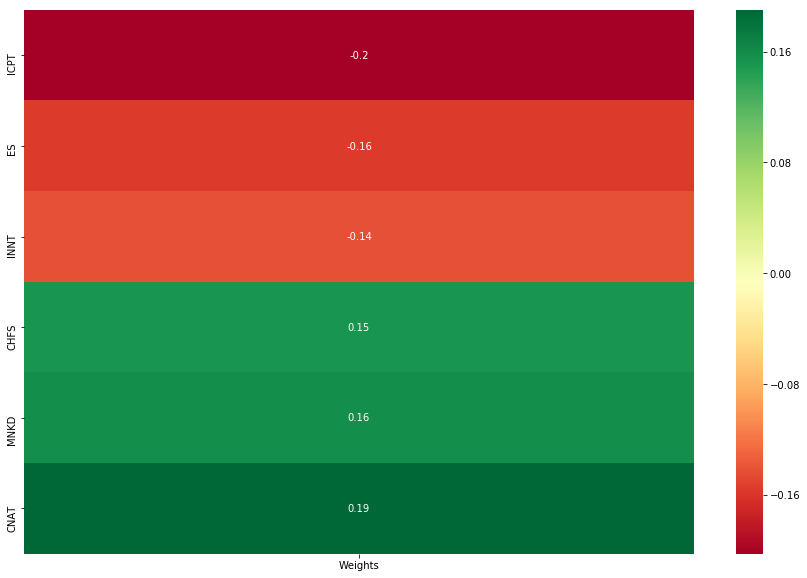

In [48]:
print("Raw Portfolio Picks")
sns.heatmap(pd.DataFrame(portfolio/2, columns=['Weights']), annot=True, cmap='RdYlGn')

Portfolio Factor Analysis


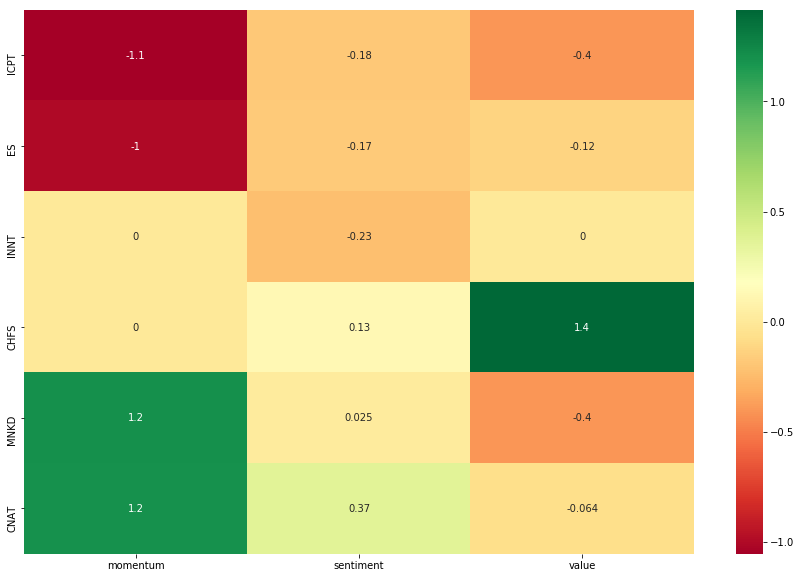

In [49]:
print("Portfolio Factor Analysis")
sns.heatmap(scores_df.drop(['composite'], axis=1), annot=True, cmap='RdYlGn')

In [50]:
COVAR_LOOKBACK = 90 # In days, not just business days
today = dt.date.today()
start = dt.date.today() - dt.timedelta(COVAR_LOOKBACK)
prices = get_stock_prices(portfolio.index, str(start), str(today))['Adj Close']

Succeeded in 1.57s after 1 attempts


In [51]:
try:
    null_locs = np.where(prices == 'null')
    for i in range(len(null_locs[0])):
        prices.iloc[null_locs[0][i], null_locs[1][i]] = np.nan
except:
    pass
prices = prices.fillna(method='pad')
prices = prices.apply(pd.to_numeric)
prices = prices.dropna(thresh=int(len(prices)*0.75), axis=1)

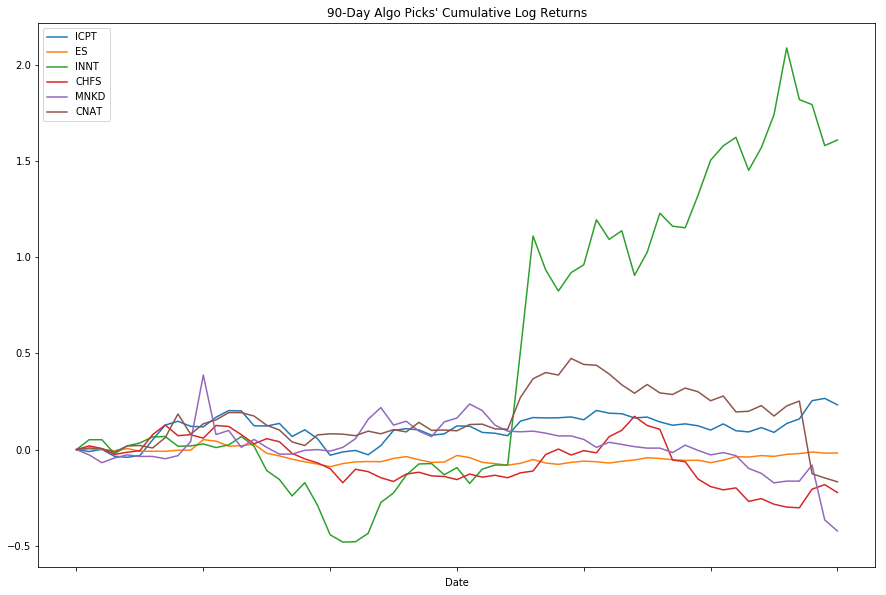

In [52]:
rets = prices.pct_change()

A = rets.dropna().T
A -= np.mean(A, axis=0)

cum_returns = (1 + rets.fillna(0)).cumprod()
np.log(cum_returns).plot(title='%d-Day Algo Picks\' Cumulative Log Returns' % COVAR_LOOKBACK)


In [53]:
A

Date  2018-01-11  2018-01-12  2018-01-16  2018-01-17  2018-01-18  2018-01-19  \
ICPT   -0.017967    0.019899   -0.013364   -0.022895    0.006688    0.053324   
ES     -0.004499    0.005352    0.015967   -0.006503   -0.015853   -0.032171   
INNT    0.044871    0.008115   -0.047514    0.023231    0.013263    0.000361   
CHFS    0.011684   -0.005509   -0.007900   -0.006591    0.006223    0.054750   
MNKD   -0.034893   -0.031726    0.047383   -0.001793   -0.010195   -0.031842   
CNAT    0.000804    0.003869    0.005429    0.014551   -0.000126   -0.044421   

Date  2018-01-22  2018-01-23  2018-01-24  2018-01-25     ...      2018-03-26  \
ICPT    0.050749    0.008243   -0.018862   -0.088653     ...        0.008526   
ES     -0.029786   -0.005724    0.007254   -0.029312     ...       -0.010882   
INNT   -0.027651   -0.060829    0.008814   -0.075258     ...        0.054060   
CHFS    0.022121   -0.065438    0.012258   -0.103580     ...       -0.040748   
MNKD   -0.041341    0.004612    0.083090    0.327054     ...       -0.011960   
CNAT    0.025909    0.119136   -0.092554   -0.030250     ...        0.001004   

Date  2018-03-27  2018-03-28  2018-03-29  2018-04-02  2018-04-03  2018-04-04  \
ICPT   -0.025431    0.042866   -0.006163   -0.029427   -0.039784    0.055280   
ES      0.027763    0.046931   -0.021243   -0.008963   -0.076212    0.034807   
INNT    0.054546   -0.108460    0.095496    0.182278    0.328434   -0.204724   
CHFS    0.019612   -0.018817   -0.014394   -0.033393   -0.101711    0.027183   
MNKD   -0.006410   -0.015021   -0.054580   -0.052965   -0.077734    0.030928   
CNAT   -0.070079    0.052501    0.000885   -0.057530   -0.032994    0.056526   

Date  2018-04-05  2018-04-06  2018-04-09  
ICPT    0.106825    0.083878   -0.013286  
ES      0.015448    0.066008    0.020680  
INNT   -0.018213   -0.120054    0.049299  
CHFS    0.108888    0.095898   -0.020325  
MNKD    0.094143   -0.175892   -0.036191  
CNAT   -0.307091    0.050162   -0.000176  

[6 rows x 60 columns]

In [54]:
from sklearn.decomposition import PCA
def visualize_PCA(data, num_components=3, title='pca'):
    samples = data
    pca = PCA(n_components=num_components, svd_solver='full')
    x_new = pca.fit_transform(samples)
    if num_components == 2:
        x_new = np.array([x_new[:, 0], x_new[:, 1]])
        plt.scatter(x_new[0], x_new[1])
        plt.title(title)
        for i in range(len(data.index)):
            plt.annotate(data.index[i], xy=(x_new[0, i],x_new[1, i]), xytext=(15,0), textcoords='offset points')
        plt.show()
    elif num_components == 3:
        x_new = np.array([x_new[:, 0], x_new[:, 1], x_new[:, 2]])
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x_new[0], x_new[1], x_new[2])
        for i in range(len(A)): #plot each point + it's index as text above
            ax.text(x_new[0,i],x_new[1,i],x_new[2,i],  A.index[i], size=10, zorder=1,  
            color='k') 
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')

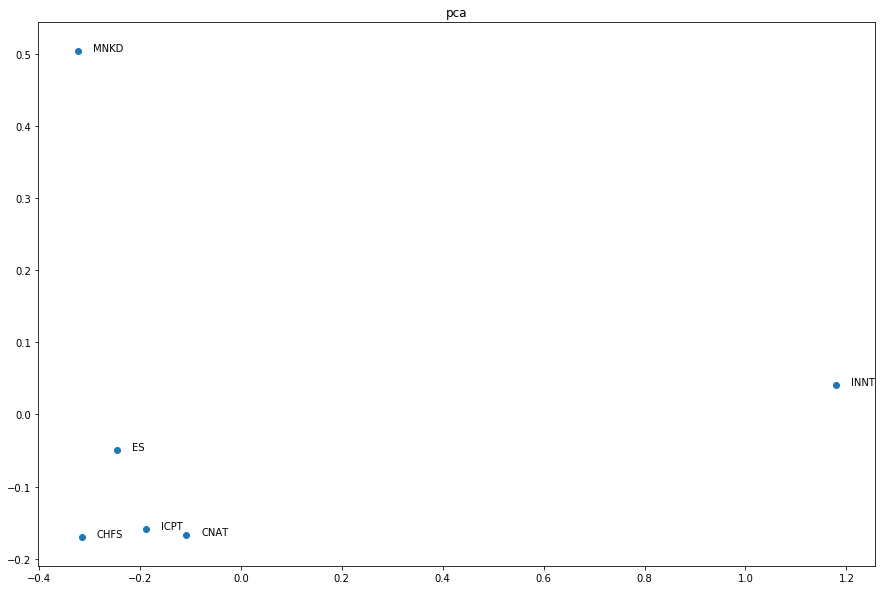

In [55]:
visualize_PCA(A, num_components=2)

3D PRINCIPLE COMPONENTS PROJECTION OF PAST 90 DAY RETURNS


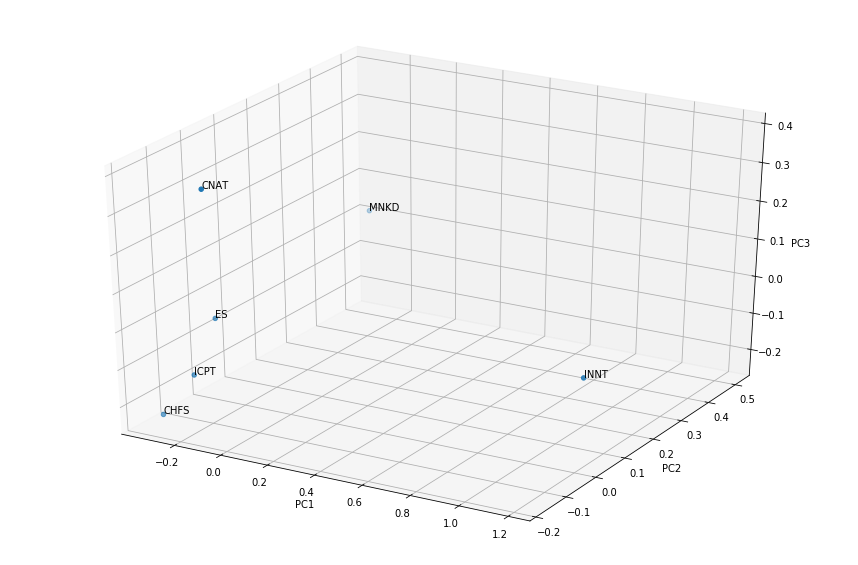

In [56]:
# Now let's project on 3 dimensions
visualize_PCA(A)

print("3D PRINCIPLE COMPONENTS PROJECTION OF PAST %d DAY RETURNS" % COVAR_LOOKBACK)

In [57]:
from sklearn.manifold import TSNE
def visualize_TSNE(data, title='tsne'):
    samples = data
    tsne = TSNE(n_components=2)
    x_new = tsne.fit_transform(samples)
    x_new = np.array([x_new[:, 0], x_new[:, 1]])
    plt.scatter(x_new[0], x_new[1])
    for i in range(len(data.index)):
            plt.annotate(data.index[i], xy=(x_new[0, i],x_new[1, i]), xytext=(15,0), textcoords='offset points')
    plt.title(title)
    plt.show()

2D TSNE of past 90 Day Returns


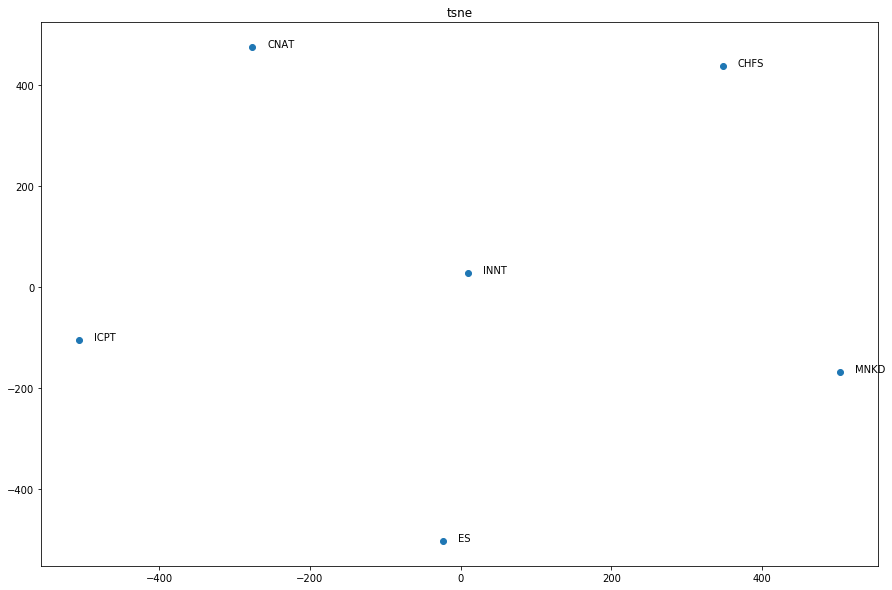

In [58]:
print('2D TSNE of past 90 Day Returns')
visualize_TSNE(A)

COVARIANCE MATRIX FROM PAST 90 DAYS RETURNS


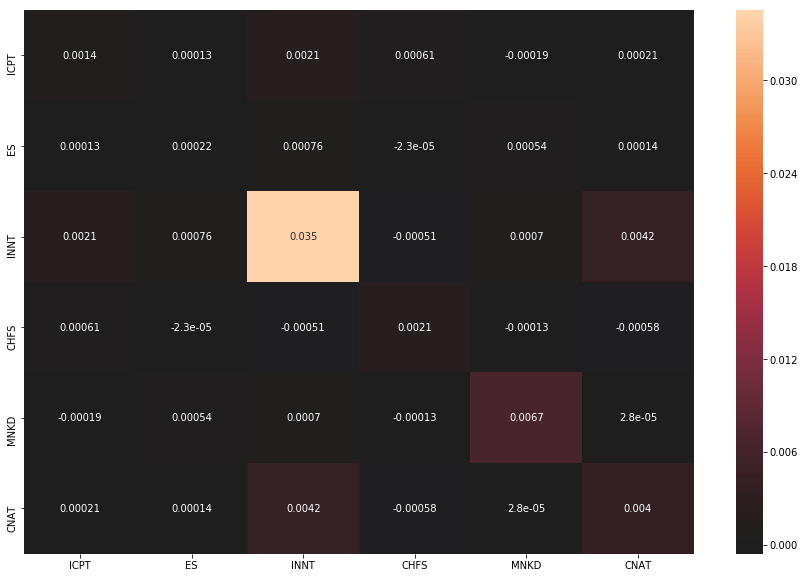

In [59]:
cov_mat = rets.dropna().cov()
print("COVARIANCE MATRIX FROM PAST %d DAYS RETURNS" % COVAR_LOOKBACK)
sns.heatmap(cov_mat, annot=True, center=0)

In [60]:
from sklearn.cluster import KMeans
def corr_matrix_data(X, num_clusters=3, x_labels = False):
    # demean the data
    X_demeaned = X - np.mean(X, 0) 
    
    _, _, V = np.linalg.svd(X_demeaned)
    V = V.T
    
    # get projected data
    X_proj = X_demeaned @ V[:, :num_clusters]
    
    # do some k-means clustering to identify which points are in which cluster
    km = KMeans(n_clusters = num_clusters)
    clusters = km.fit_predict(X_proj)
    
    # sort data based on identified clusters 
    t = X.copy()
    t['cluster'] = clusters
    t = t.sort_values("cluster")
    t = t.drop("cluster", 1)
    plt.imshow(t.T.corr(), "hot")
    plt.colorbar()
    plt.grid(False)
    plt.yticks(range(len(X)), t.index)
    if x_labels:
        plt.xticks(range(len(X)), t.index)
    

Unclustered Correlation Matrix Heat Map


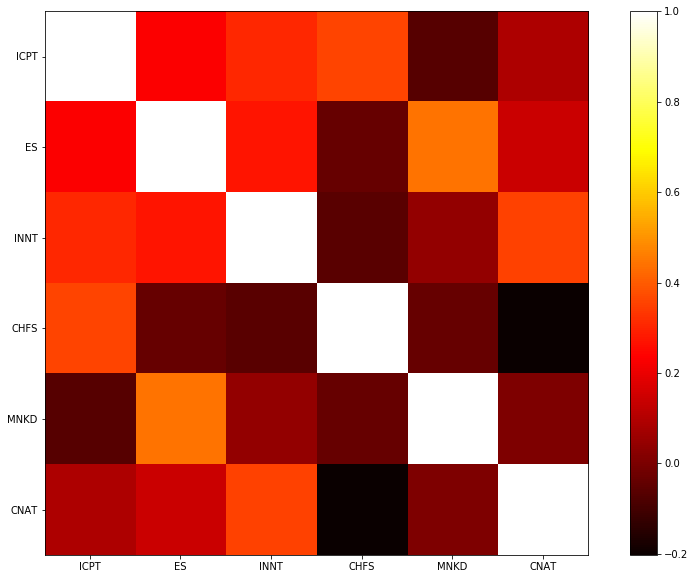

In [61]:
print("Unclustered Correlation Matrix Heat Map")
plt.imshow(rets.dropna().corr(), "hot")
plt.colorbar()
plt.grid(False)
_ = plt.xticks(range(rets.shape[1]), rets.columns)
_ = plt.yticks(range(rets.shape[1]), rets.columns)

2-Clustered Correlation Matrix Heat Map


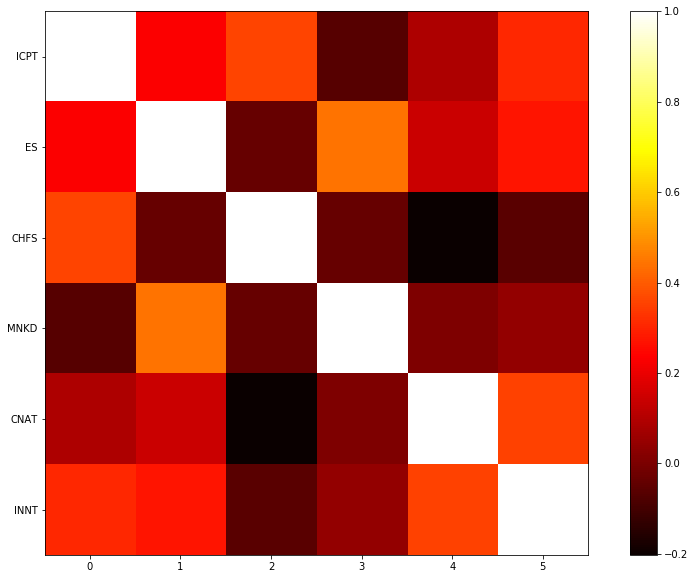

In [62]:
NUM_CLUSTERS = 2
print("%d-Clustered Correlation Matrix Heat Map" % NUM_CLUSTERS)
clusters = corr_matrix_data(rets.dropna().T, num_clusters=NUM_CLUSTERS)

In [63]:
print("Groupings:\n" + str(clusters))

Groupings:
None


In [64]:
return_sd = pd.DataFrame(index = A.index)
return_sd['E[r]'] = returns
return_sd['vol'] = [np.sqrt(cov_mat.iloc[i, i]) for i in range(len(cov_mat))]

In [65]:
def get_MVP(mu_vec, cov_mat, mark_vols, mark_rets, stocks):
    MVP_index = np.argmin(mark_vols)
    MVP = opt_weight(mark_rets[MVP_index], cov_mat, mu_vec)
    MVP_series = pd.Series(index=stocks, data=MVP.reshape((len(MVP))))
    print("Minimum Variance Portfolio:\n" + str(MVP_series.sort_values()))
    
    return MVP_series

In [66]:
def get_market_port(mu_vec, cov_mat, mark_vols, mark_rets, rf, stocks):
    derivatives = []
    for i in range(1, len(mark_rets) - 1):
        derivative = (mark_rets[i + 1] - mark_rets[i - 1]) / (mark_vols[i + 1] - mark_vols[i - 1])
        derivatives.append(derivative)
        
    cap_mkts_slopes = []
    for i in range(1, len(mark_rets) - 1):
        cap_mkts_slope = (mark_rets[i] - rf) / mark_vols[i]
        cap_mkts_slopes.append(cap_mkts_slope)
        
    MVP_index = np.argmax(derivatives)
    market_portfolio_index = np.argmin((np.array(derivatives[MVP_index:]) - np.array(cap_mkts_slopes[MVP_index:]))**2)
    market_portfolio_index += MVP_index
    market_portfolio_ret = mark_rets[market_portfolio_index - 1]
    market_portfolio = opt_weight(market_portfolio_ret, cov_mat, mu_vec)
    market_port_series = pd.Series(index=stocks, data=market_portfolio.reshape((len(market_portfolio))))
    
    cap_mkt_slope = cap_mkts_slopes[market_portfolio_index]
    
    print("Market Portfolio, assuming risk-free rate of %.2f:\n" % rf + str(market_port_series.sort_values()))
    
    return market_port_series, cap_mkt_slope
    

In [67]:
RF_RATE = 0.03

def plot_eff_front(mu_vec, cov_mat, stocks):
    mu_vec = mu_vec.reshape((len(mu_vec), 1))
    rets = np.linspace(-2 * np.abs(min(mu_vec)), 2*np.abs(max(mu_vec)), 100)
    vols = [get_vol(opt_weight(r, cov_mat, mu_vec), cov_mat) for r in rets]
    
    MVP = get_MVP(mu_vec, cov_mat, vols, rets, stocks)
    market_port, cap_mkt_slope = get_market_port(mu_vec, cov_mat, vols, rets, RF_RATE, stocks)
    x = np.linspace(0, max(vols), 100)
    cap_mkts_line = [RF_RATE + cap_mkt_slope*x for x in x]
    
    plt.plot(vols, rets)
    plt.plot(x, cap_mkts_line)
    plt.xlim(xmin=0)
    
    return MVP, market_port

In [68]:
print("Return-Volatility Table:\n", return_sd)

Return-Volatility Table:
           E[r]       vol
ICPT -0.096810  0.037231
ES   -0.083815  0.014888
INNT -0.015783  0.185843
CHFS  0.056372  0.045623
MNKD  0.069384  0.082069
CNAT  0.103129  0.063206


Minimum Variance Portfolio:
MNKD   -0.045971
INNT   -0.019058
ICPT    0.016705
CNAT    0.041031
CHFS    0.087432
ES      0.919862
dtype: float64
Market Portfolio, assuming risk-free rate of 0.03:
ICPT   -0.455315
ES     -0.262335
INNT   -0.010080
MNKD    0.227851
CNAT    0.589325
CHFS    0.910554
dtype: float64


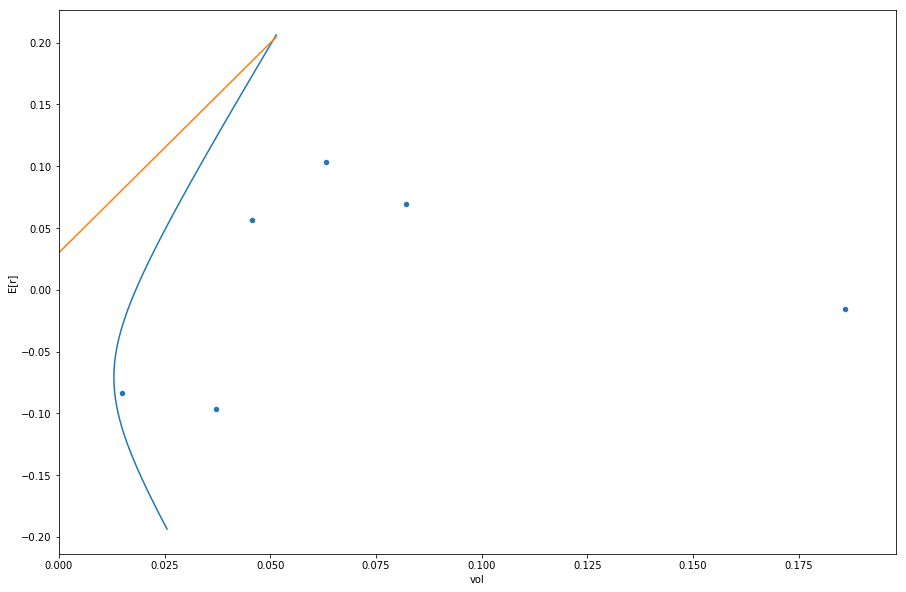

In [69]:
return_sd.plot.scatter(x='vol', y='E[r]')
MVP1, market_port1 = plot_eff_front(np.array(return_sd['E[r]']), np.array(cov_mat), return_sd.index)

In [70]:
def unlever_portfolio(portfolio):
    unlevered_port = portfolio.copy()
    short_sum = 0
    long_sum = 0
    for weight in unlevered_port:
        if weight < 0:
            short_sum -= weight
        else:
            long_sum += weight
            
    for i in range(len(unlevered_port)):
        if unlevered_port[i] < 0:
            unlevered_port[i] /= short_sum
        else:
            unlevered_port[i] /= long_sum

    if short_sum != 0:
        unlevered_port /= 2
            
    return unlevered_port

Unlevered Minimum Variance Portfolio


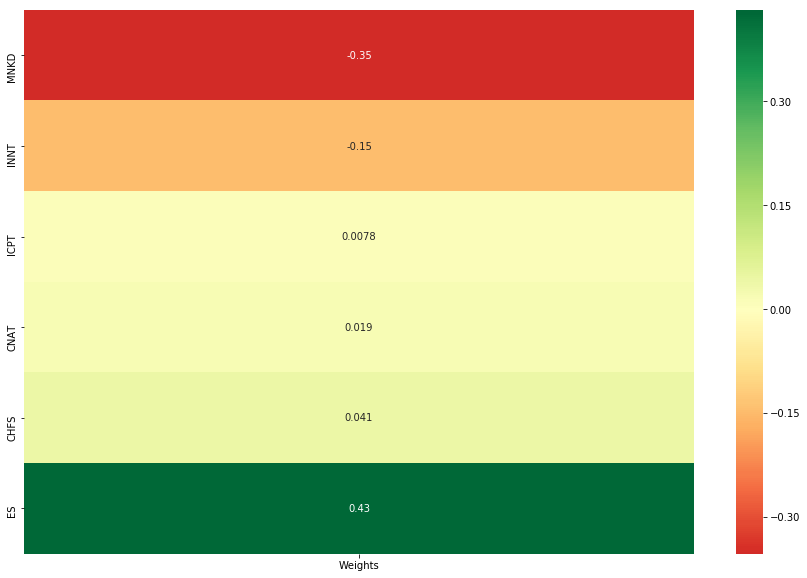

In [71]:
unlevered_MVP1 = unlever_portfolio(MVP1)
print("Unlevered Minimum Variance Portfolio")
sns.heatmap(pd.DataFrame(unlevered_MVP1, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

Unlevered Market Portfolio


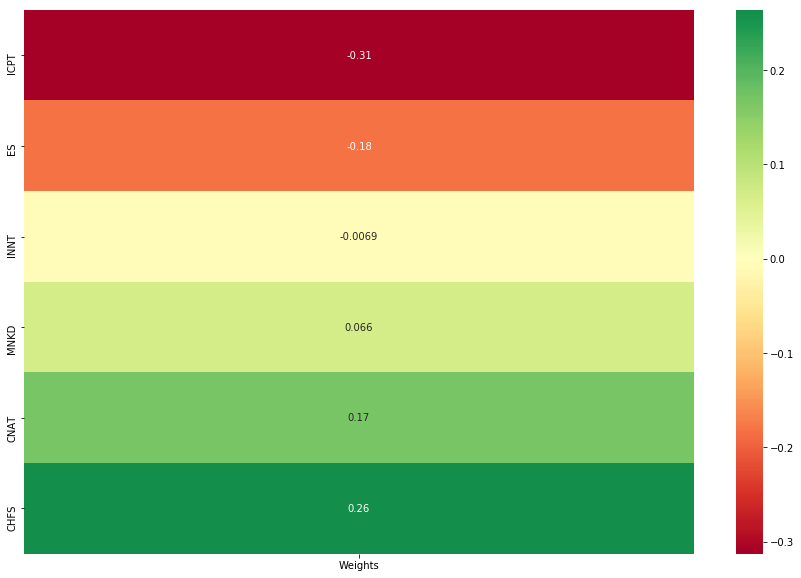

In [72]:
unlevered_market_port1 = unlever_portfolio(market_port1)
print("Unlevered Market Portfolio")
sns.heatmap(pd.DataFrame(unlevered_market_port1, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

# Analysis of Other Top and Bottom Stocks

In [73]:
all_scores = pd.concat([bottom_scores_df, top_scores_df], axis=0)
returns = get_expected_returns(all_scores.index, all_scores['composite'])

Score Scaler:  -0.8029039791566671


Factor Analysis


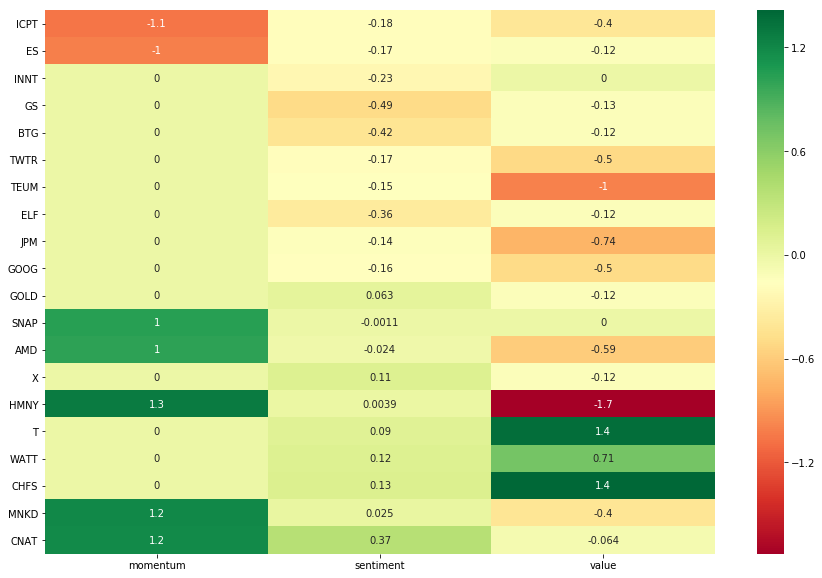

In [74]:
print("Factor Analysis")
sns.heatmap(all_scores.drop(['composite'], axis=1), annot=True, cmap='RdYlGn')

In [75]:
COVAR_LOOKBACK = 90 # In days, not just business days
today = dt.date.today()
start = dt.date.today() - dt.timedelta(COVAR_LOOKBACK)
prices = get_stock_prices(all_scores.index, str(start), str(today))['Adj Close']

Succeeded in 2.69s after 1 attempts


In [76]:
try:
    null_locs = np.where(prices == 'null')
    for i in range(len(null_locs[0])):
        prices.iloc[null_locs[0][i], null_locs[1][i]] = np.nan
except:
    pass
prices = prices.fillna(method='pad')
prices = prices.apply(pd.to_numeric)
prices = prices.dropna(thresh=int(len(prices)*0.75), axis=1)

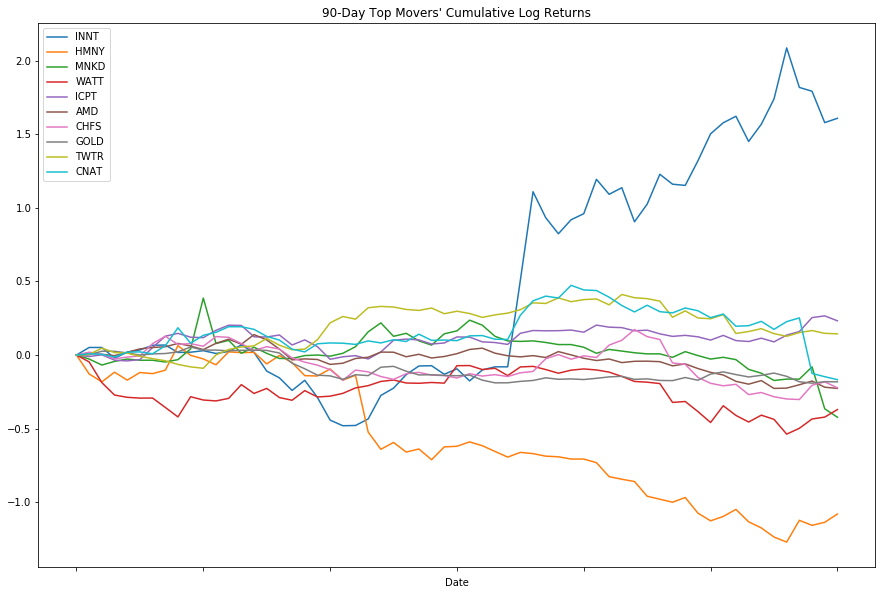

In [77]:
rets = prices.pct_change()

A = rets.dropna().T
A -= np.mean(A, axis=0)


cum_returns = (1 + rets.fillna(0)).cumprod()
top_movers = np.abs(cum_returns.iloc[-1] - 1).sort_values(ascending=False).head(10).index
np.log(cum_returns)[top_movers].plot(title='%d-Day Top Movers\' Cumulative Log Returns' % COVAR_LOOKBACK)


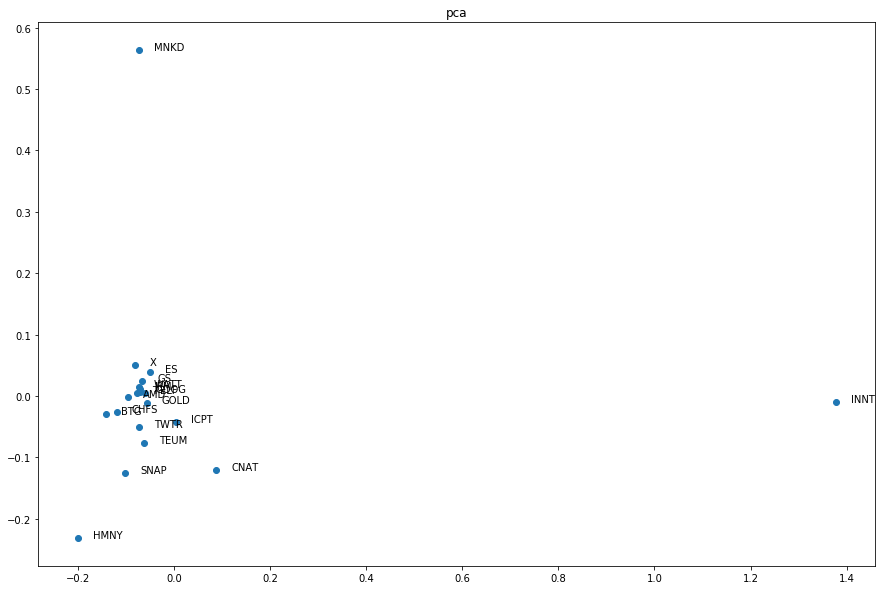

In [78]:
visualize_PCA(A, num_components=2)

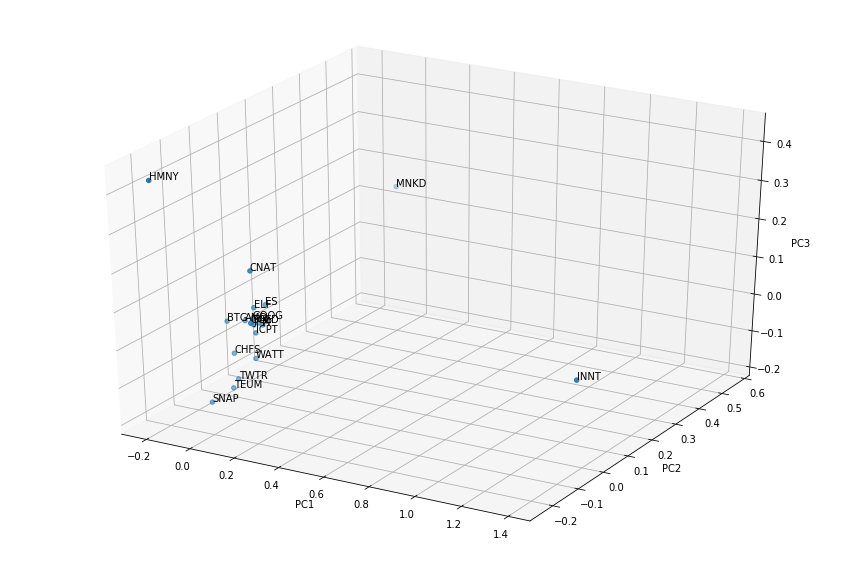

In [79]:
# Now let's project on 3 dimensions
visualize_PCA(A)

2D TSNE of past 90 Day Returns


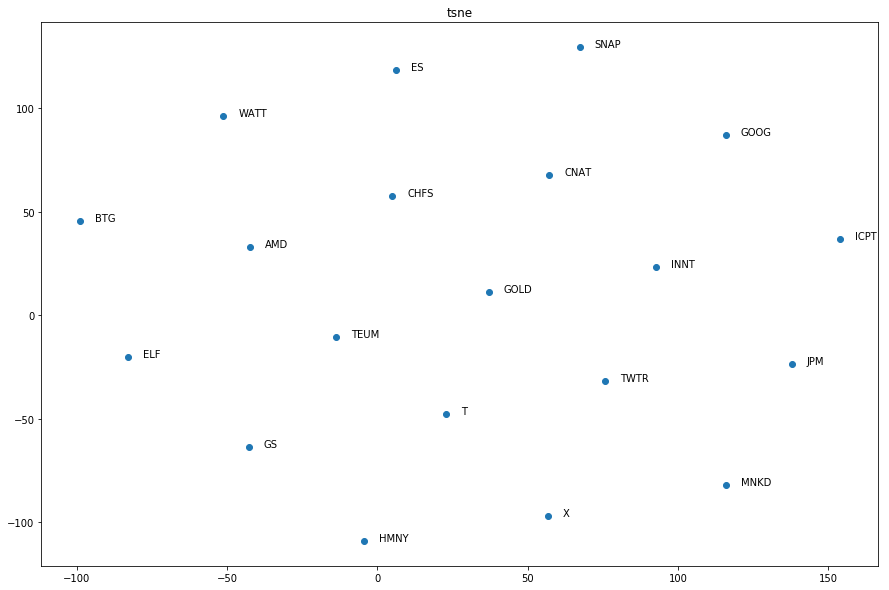

In [80]:
print('2D TSNE of past 90 Day Returns')
visualize_TSNE(A)

COVARIANCE MATRIX FROM PAST 90 DAYS RETURNS


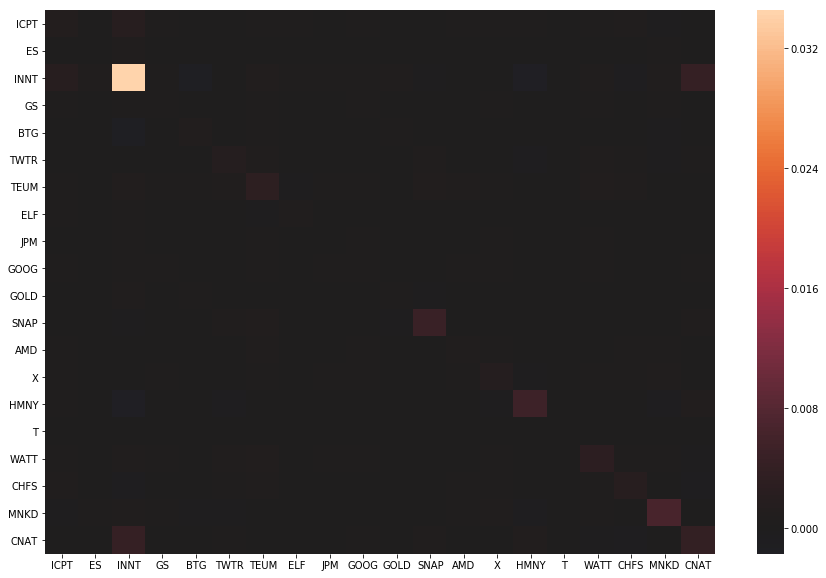

In [81]:
cov_mat = rets.dropna().cov()
print("COVARIANCE MATRIX FROM PAST %d DAYS RETURNS" % COVAR_LOOKBACK)
sns.heatmap(cov_mat, annot=False, center=0)

Unclustered Correlation Matrix Heat Map


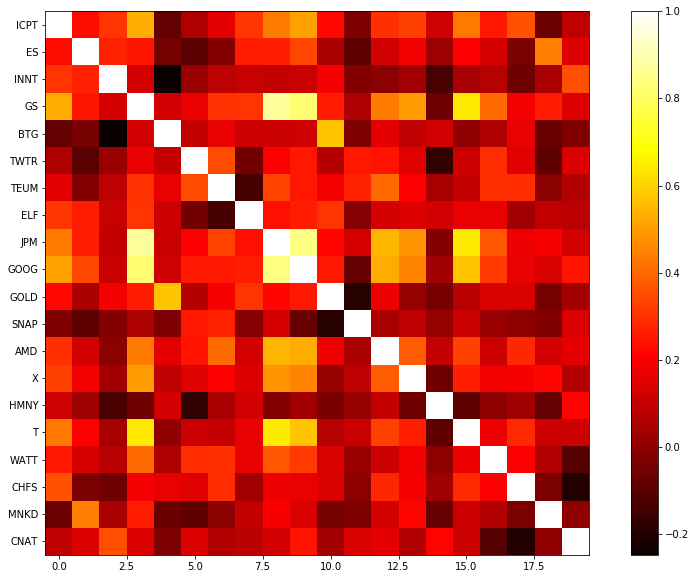

In [82]:
print("Unclustered Correlation Matrix Heat Map")
plt.imshow(rets.dropna().corr(), "hot")
plt.colorbar()
plt.grid(False)
_ = plt.yticks(range(rets.shape[1]), rets.columns)

3-Clustered Correlation Matrix Heat Map


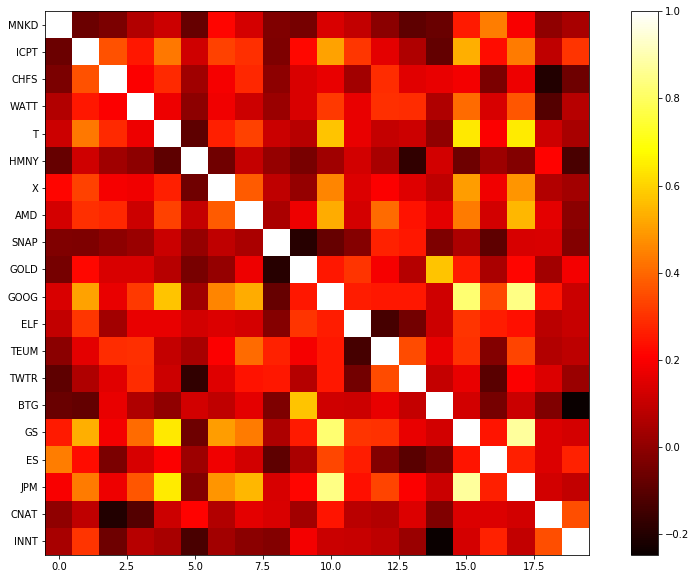

In [83]:
NUM_CLUSTERS = 3
print("%d-Clustered Correlation Matrix Heat Map" % NUM_CLUSTERS)
clusters = corr_matrix_data(rets.dropna().T, num_clusters=NUM_CLUSTERS)

In [84]:
print("Groupings:\n" + str(clusters))

Groupings:
None


In [85]:
return_sd = pd.DataFrame(index = A.index)
return_sd['E[r]'] = returns
return_sd['vol'] = [np.sqrt(cov_mat.iloc[i, i]) for i in range(len(cov_mat))]

In [86]:
print("Using scores as expected returns, Return-Volatility Table:\n", return_sd)

Using scores as expected returns, Return-Volatility Table:
           E[r]       vol
ICPT -0.459984  0.037231
ES   -0.398240  0.014888
INNT -0.074991  0.185843
GS   -0.177281  0.019022
BTG  -0.154639  0.029485
TWTR -0.136333  0.040856
TEUM -0.207230  0.056519
ELF  -0.133603  0.025634
JPM  -0.164997  0.016718
GOOG -0.132319  0.020258
GOLD  0.000723  0.020795
SNAP  0.332643  0.068959
AMD   0.223207  0.027350
X     0.017182  0.038055
HMNY  0.136574  0.072532
T     0.248418  0.013925
WATT  0.152632  0.054500
CHFS  0.267849  0.045623
MNKD  0.329672  0.082069
CNAT  0.490012  0.063206


Minimum Variance Portfolio:
GOOG   -0.251032
ICPT   -0.072461
BTG    -0.032633
MNKD   -0.032296
WATT   -0.020944
TEUM   -0.009614
INNT   -0.006948
CNAT   -0.004461
SNAP    0.005498
AMD     0.008327
CHFS    0.008628
ELF     0.010046
X       0.023585
HMNY    0.033969
TWTR    0.068283
GS      0.116076
JPM     0.137216
GOLD    0.213612
T       0.355228
ES      0.449921
dtype: float64
Market Portfolio, assuming risk-free rate of 0.03:
JPM    -0.775952
GS     -0.390109
ICPT   -0.278630
ES     -0.264629
BTG    -0.169876
TWTR   -0.042013
TEUM   -0.034052
CHFS    0.007938
INNT    0.010106
CNAT    0.012602
ELF     0.013041
MNKD    0.030567
SNAP    0.057604
HMNY    0.067014
WATT    0.105603
X       0.145360
AMD     0.206610
GOOG    0.258286
GOLD    0.520795
T       1.519733
dtype: float64


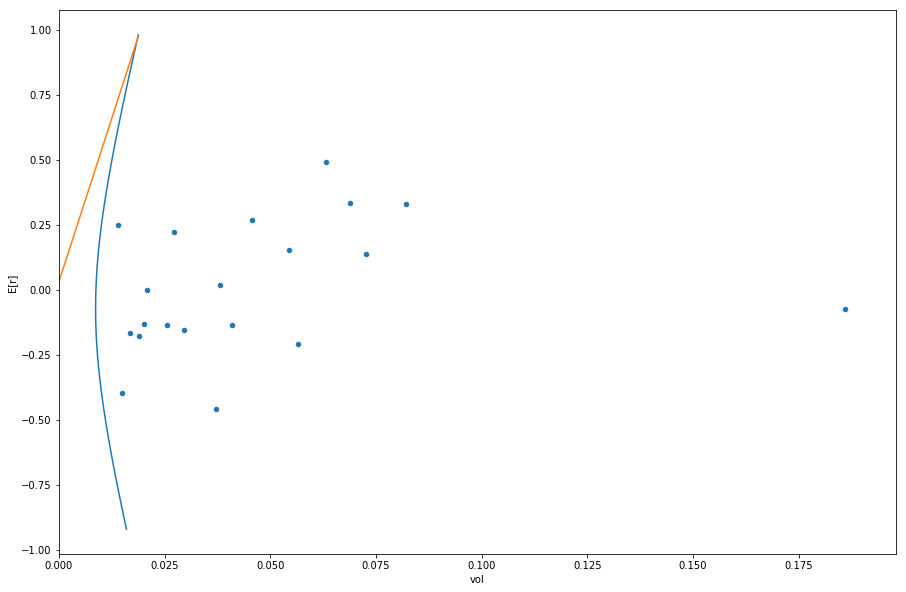

In [87]:
return_sd.plot.scatter(x='vol', y='E[r]')
MVP2, market_port2 = plot_eff_front(np.array(return_sd['E[r]']), np.array(cov_mat), return_sd.index)

Unlevered Minimum Variance Portfolio


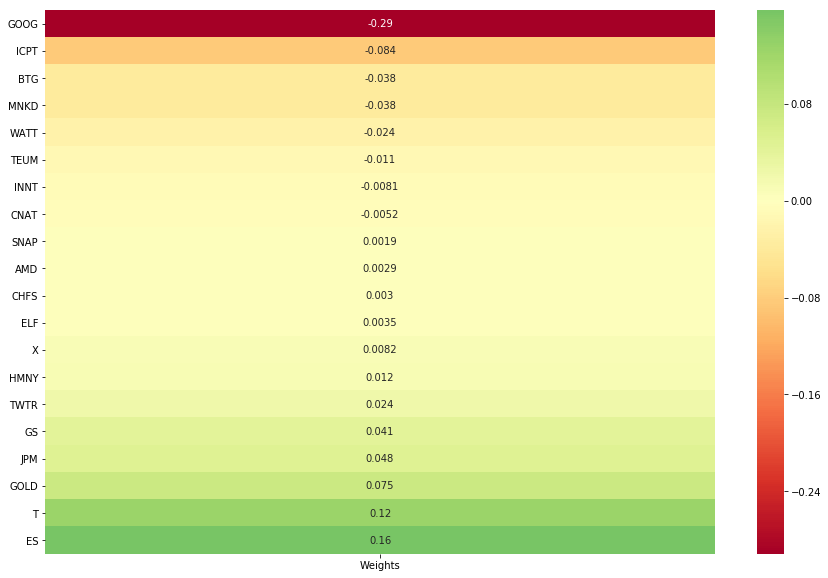

In [88]:
unlevered_MVP2 = unlever_portfolio(MVP2)
print("Unlevered Minimum Variance Portfolio")
sns.heatmap(pd.DataFrame(unlevered_MVP2, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)

Unlevered Market Portfolio


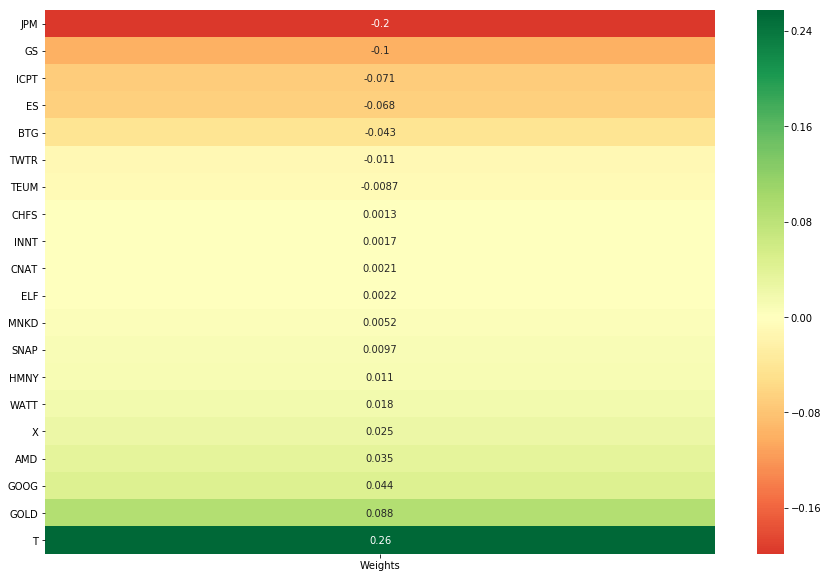

In [89]:
unlevered_market_port2 = unlever_portfolio(market_port2)
print("Unlevered Market Portfolio")
sns.heatmap(pd.DataFrame(unlevered_market_port2, columns=['Weights']).sort_values('Weights'), annot=True, cmap='RdYlGn', center=0)